<a href="https://colab.research.google.com/github/sartaj0/Simple-AI-Projects/blob/main/Kaggle_SelfDriving_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip -q lyft-udacity-challenge.zip
!rm -r lyft-udacity-challenge.zip

100% 5.10G/5.11G [01:46<00:00, 80.6MB/s]
100% 5.11G/5.11G [01:46<00:00, 51.7MB/s]


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
"""
labels = { 0: 'Unlabeled', 1:'Building', 2:'Fence', 3:'Other', 4:'Pedestrian',
          5:'Pole', 6:'Roadline', 7:'Road', 8:'Sidewalk', 
          9:'Vegetation', 10:'Car', 11:'Wall', 12:'Traffic sign' }"""

"\nlabels = { 0: 'Unlabeled', 1:'Building', 2:'Fence', 3:'Other', 4:'Pedestrian',\n          5:'Pole', 6:'Roadline', 7:'Road', 8:'Sidewalk', \n          9:'Vegetation', 10:'Car', 11:'Wall', 12:'Traffic sign' }"

In [5]:
def generate(folders, img_size):
  x_train = []
  y_train = []
  for folder in folders:
    current_folder = os.path.join(folder, os.listdir(folder)[0])
    x_folder = os.path.join(current_folder, "CameraRGB")
    y_folder = os.path.join(current_folder, "CameraSeg")
    for img in os.listdir(y_folder):

      x = Image.open(os.path.join(x_folder, img))
      y = Image.open(os.path.join(y_folder, img))

      x = x.resize(img_size)
      y = y.resize(img_size)

      x = np.array(x)
      y = np.array(y)[:, :, 0]

      x_train.append(x)
      y_train.append(y)
  x_train = np.array(x_train) / 255.0
  y_train = np.array(y_train)
  y_train[y_train > 12] = 0
  return x_train, y_train.reshape(-1, img_size[1], img_size[0], 1)

In [6]:
x_train, y_train = generate(['dataA', 'dataB', 'dataC', 'dataE'], img_size=(224, 224))

In [7]:
np.unique(y_train,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8),
 array([58842748, 17375163,  2246326,  2845175,  1417825,  1889967,
         3119409, 40704491, 18957793, 19018408, 33014268,  1159045,
          113382]))

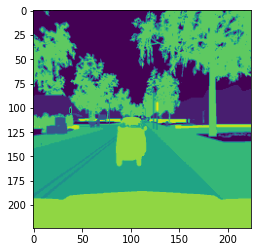

In [8]:
plt.imshow(y_train[1500].reshape(224, 224))

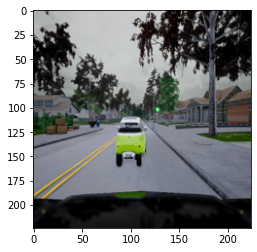

In [9]:
plt.imshow(x_train[1500])

In [10]:
x_train.shape

(4000, 224, 224, 3)

In [11]:
y_train.shape

(4000, 224, 224, 1)

In [12]:
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)

In [13]:
x_train.shape

(3600, 224, 224, 3)

In [14]:
x_test.shape

(400, 224, 224, 3)

In [15]:
from tensorflow.keras import layers
from tensorflow import keras

In [16]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
# model = get_model((224, 224), num_classes=15)
model = get_model((224, 224), num_classes=13)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("kaggle_challenge.h5", save_best_only=True)
]
epochs = 200

In [18]:

model.fit(x=x_train, y=y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/200
113/113 [==============================] - 58s 424ms/step - loss: 1.5829 - accuracy: 0.6953 - val_loss: 2.5840 - val_accuracy: 0.3494
Epoch 2/200
113/113 [==============================] - 47s 416ms/step - loss: 0.5364 - accuracy: 0.8432 - val_loss: 1.7055 - val_accuracy: 0.4304
Epoch 3/200
113/113 [==============================] - 48s 425ms/step - loss: 0.4720 - accuracy: 0.8606 - val_loss: 2.0585 - val_accuracy: 0.3814
Epoch 4/200
113/113 [==============================] - 49s 430ms/step - loss: 0.4331 - accuracy: 0.8708 - val_loss: 1.6168 - val_accuracy: 0.5506
Epoch 5/200
113/113 [==============================] - 48s 429ms/step - loss: 0.4069 - accuracy: 0.8777 - val_loss: 0.8699 - val_accuracy: 0.7763
Epoch 6/200
113/113 [==============================] - 48s 427ms/step - loss: 0.3906 - accuracy: 0.8821 - val_loss: 0.4323 - val_accuracy: 0.8710
Epoch 7/200
113/113 [==============================] - 48s 428ms/step - loss: 0.3754 - accuracy: 0.8869 - val_loss: 0.3867 -

In [19]:
prediction = model.predict(x_test)

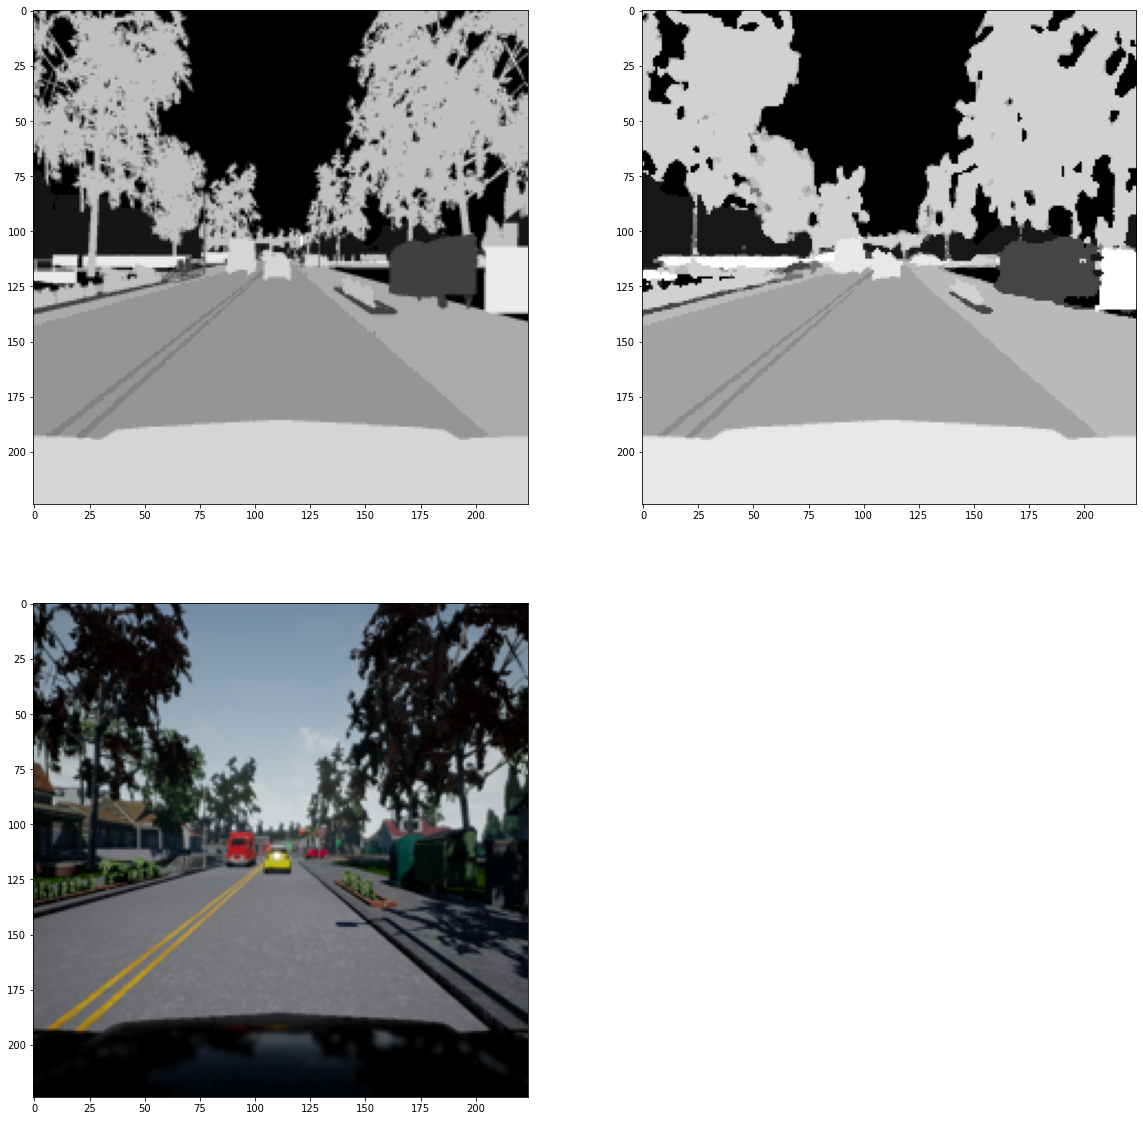

In [20]:

fig=plt.figure(figsize=(20, 20))
fig.add_subplot(2, 2, 1)
plt.imshow(y_test[0].reshape(224, 224), cmap="gray",)
fig.add_subplot(2, 2, 2)
plt.imshow(np.argmax(prediction[0], axis=2).reshape(224, 224), cmap="gray")
fig.add_subplot(2, 2, 3)
plt.imshow(x_test[0])

In [21]:
import cv2

In [22]:
output = prediction[0].argmax(axis=2)

In [23]:
x_test.shape

(400, 224, 224, 3)

In [24]:
output.shape

(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


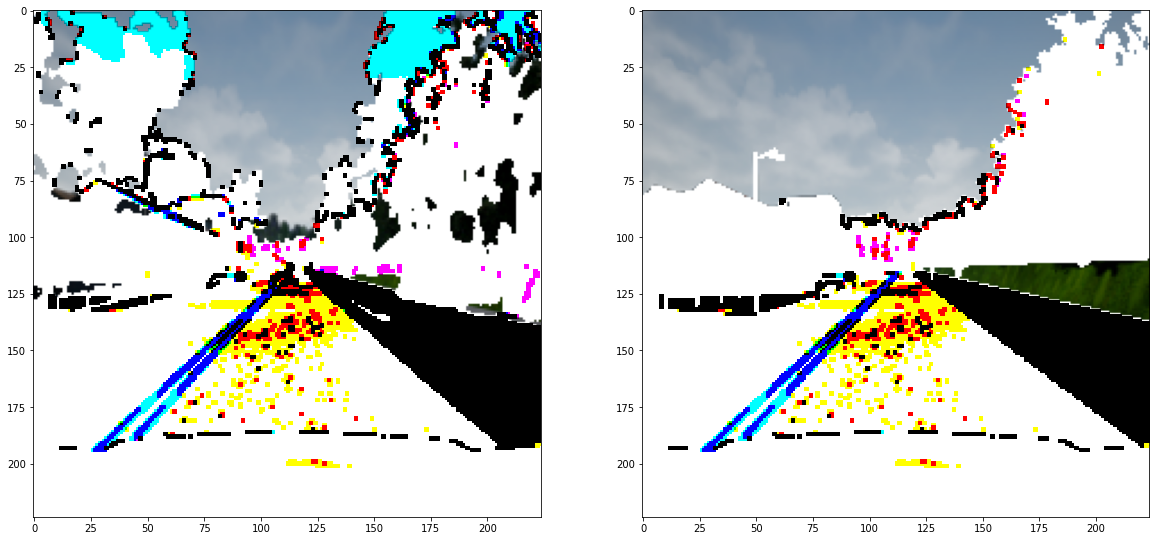

In [26]:
i = 12

fig=plt.figure(figsize=(20, 20))

img1 = np.zeros(x_test[i].shape)

img1[:,:,0]=output.reshape(224, 224)
img1[:,:,1]=output.reshape(224, 224)
img1[:,:,2]=output.reshape(224, 224)
img = cv2.bitwise_or(x_test[i], img1)
fig.add_subplot(1,2,1)
plt.imshow(img)

img2 = np.zeros(x_test[0].shape)
img2[:,:,0]=y_test[i].reshape(224, 224)
img2[:,:,1]=y_test[i].reshape(224, 224)
img2[:,:,2]=y_test[i].reshape(224, 224)
img = cv2.bitwise_or(x_test[i], img2)
fig.add_subplot(1,2,2)
plt.imshow(img)